# 2D iterative MENT solver

In [1]:
import numpy as np
import proplot as pplt
import scipy.interpolate
import torch
from tqdm.notebook import tqdm

import mentflow as mf
from mentflow.utils import grab

In [2]:
pplt.rc["cmap.discrete"] = False
pplt.rc["cmap.sequential"] = "viridis"
pplt.rc["figure.facecolor"] = "white"
pplt.rc["grid"] = False

## Data

In [3]:
device = torch.device("cpu")
precision = torch.float32

def send(x):
    return x.type(precision).to(device)

In [4]:
data_name = "swissroll"
data_size = int(1.00e+06)
data_noise = None
xmax = 3.25
n_bins = 75
n_meas = 4

dist = mf.data.toy.gen_dist(data_name, noise=data_noise)
x0 = dist.sample(data_size)
x0 = send(x0)

angles = np.linspace(0.0, np.pi, n_meas, endpoint=False)
transfer_matrices = []
for angle in angles:
    matrix = mf.transform.rotation_matrix(angle)
    matrix = send(matrix)
    transfer_matrices.append(matrix)

transforms = []
for matrix in transfer_matrices:
    transform = mf.transform.Linear(matrix)
    transform = transform.to(device)
    transforms.append(transform)

bin_edges = torch.linspace(-xmax, xmax, n_bins + 1)
diagnostic = mf.diagnostics.Histogram1D(axis=0, bin_edges=bin_edges, kde=False)
diagnostic = diagnostic.to(device)

measurements = [diagnostic(transform(x0)) for transform in transforms]

## Model

In [5]:
prior = mf.models.ment.GaussianPrior(d=2, scale=2.0, device=device)

sampler = mf.sample.GridSampler(limits=(2 * [(-xmax, xmax)]), res=200, device=device)

model = mf.models.ment.MENT_2D1D(
    transforms=transforms,
    measurements=measurements,
    diagnostic=diagnostic,
    prior=prior,
    sampler=sampler,
    interpolate="pchip",  # {"nearest", "linear", "pchip"}
    device=device,
)

## Training

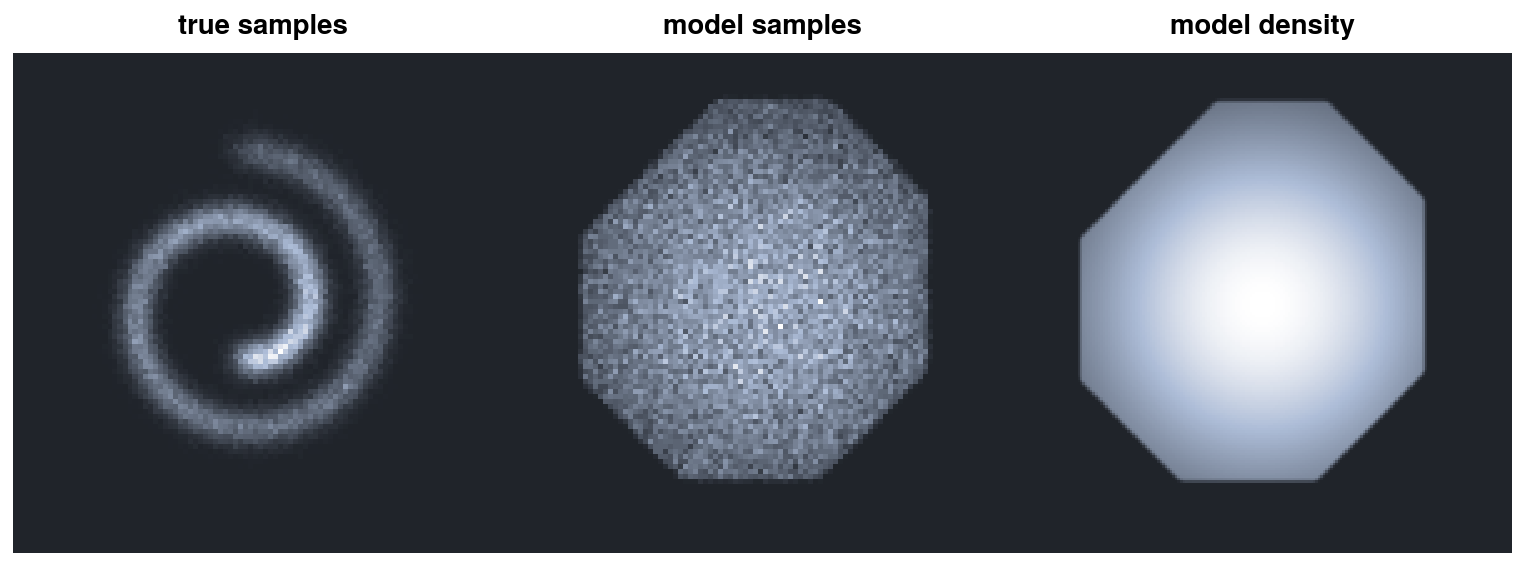

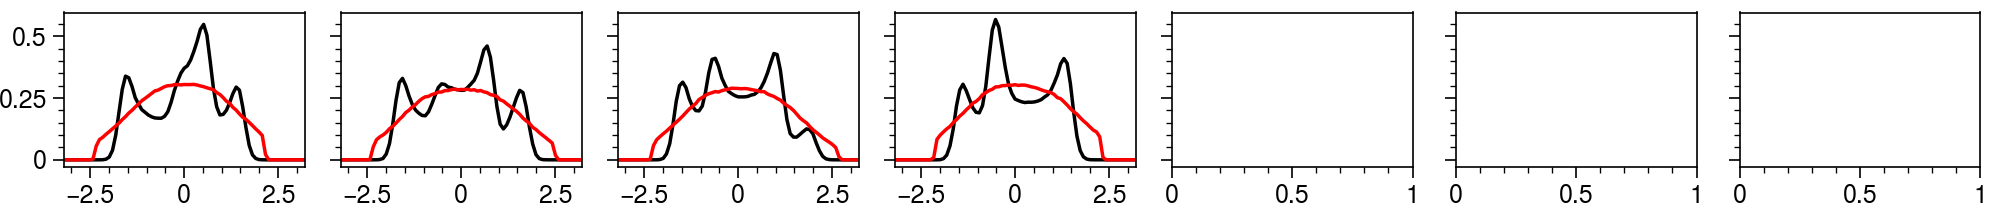

iteration = 0
discrepancy = 4.120546340942383


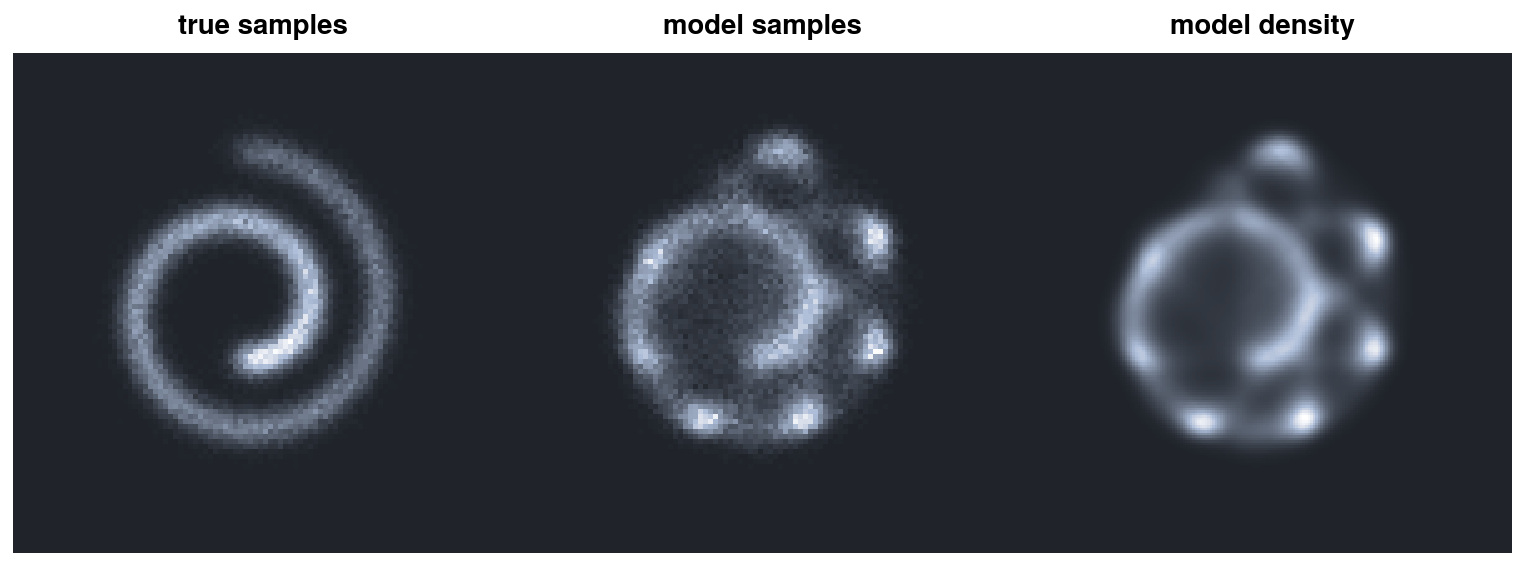

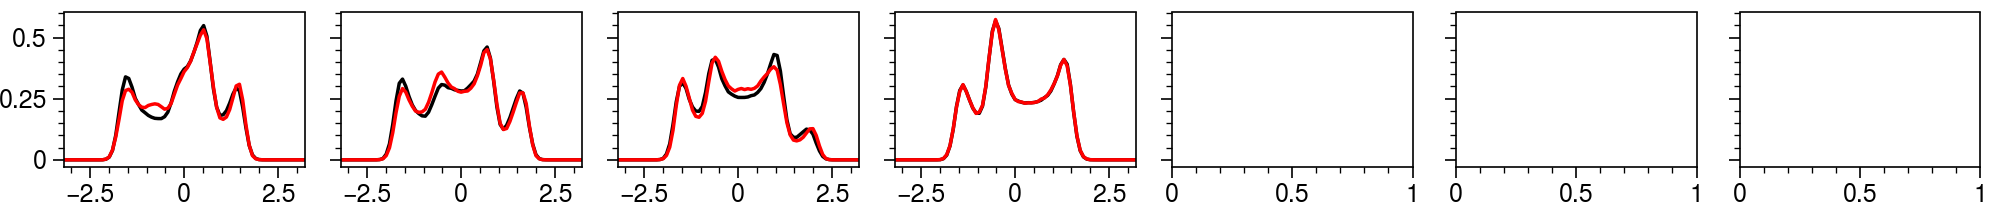

iteration = 1
discrepancy = 0.7176163792610168


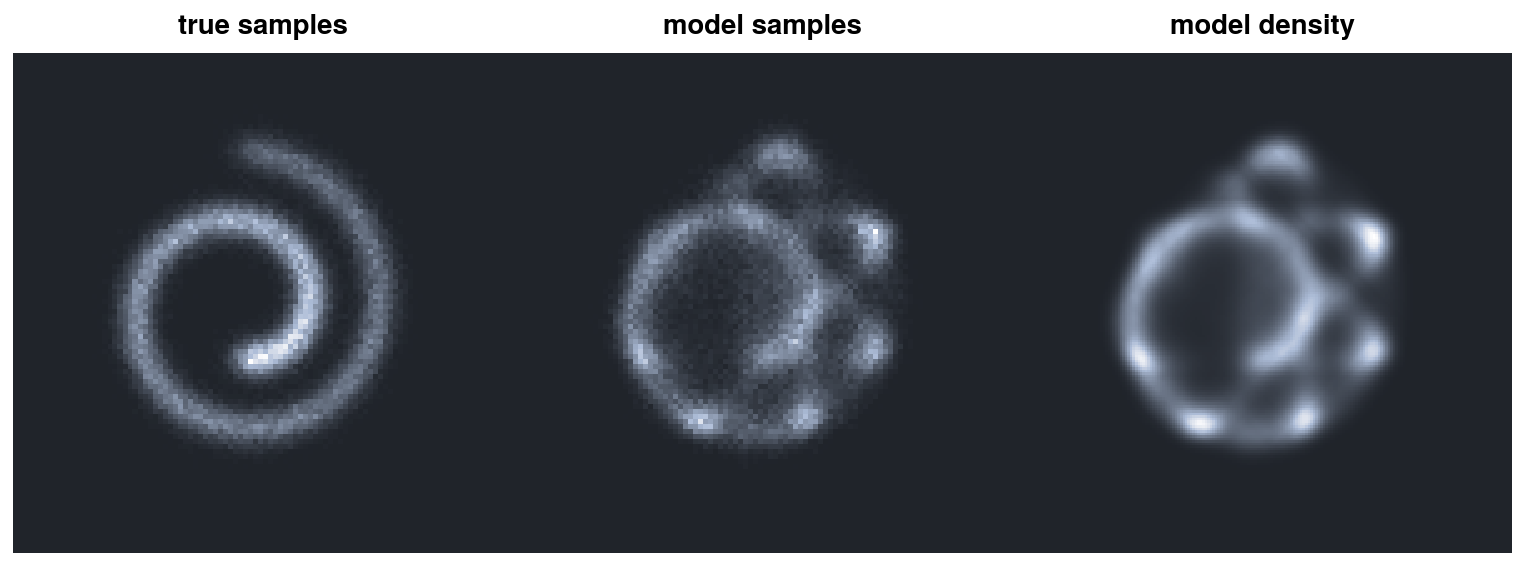

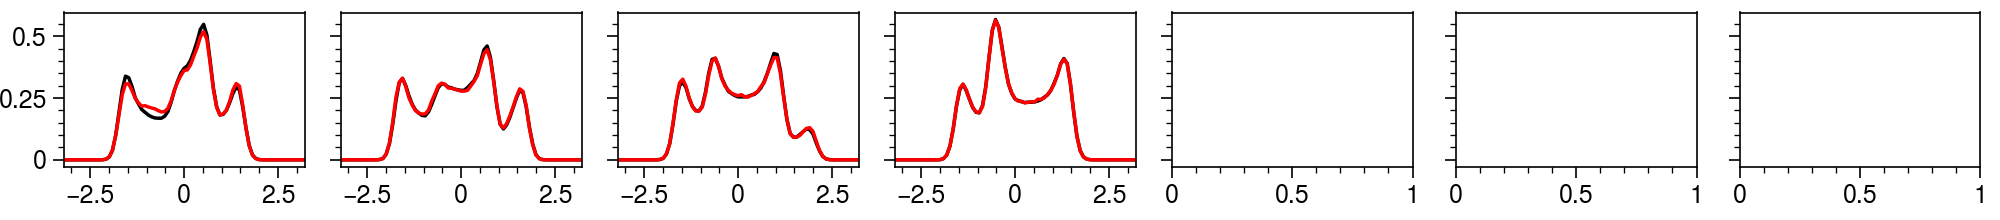

iteration = 2
discrepancy = 0.2937971353530884


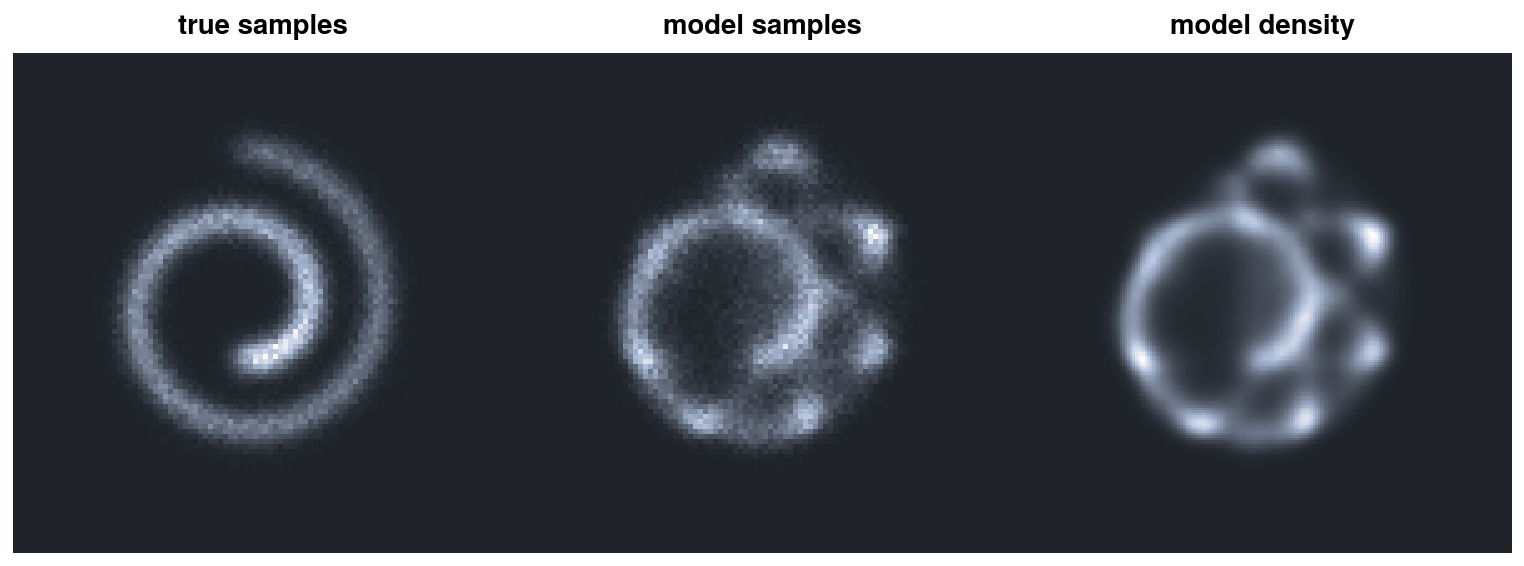

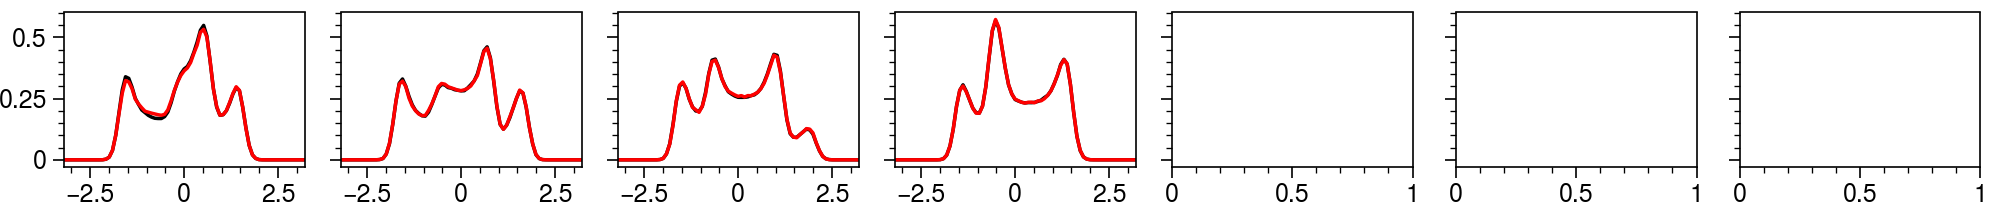

iteration = 3
discrepancy = 0.15136121213436127


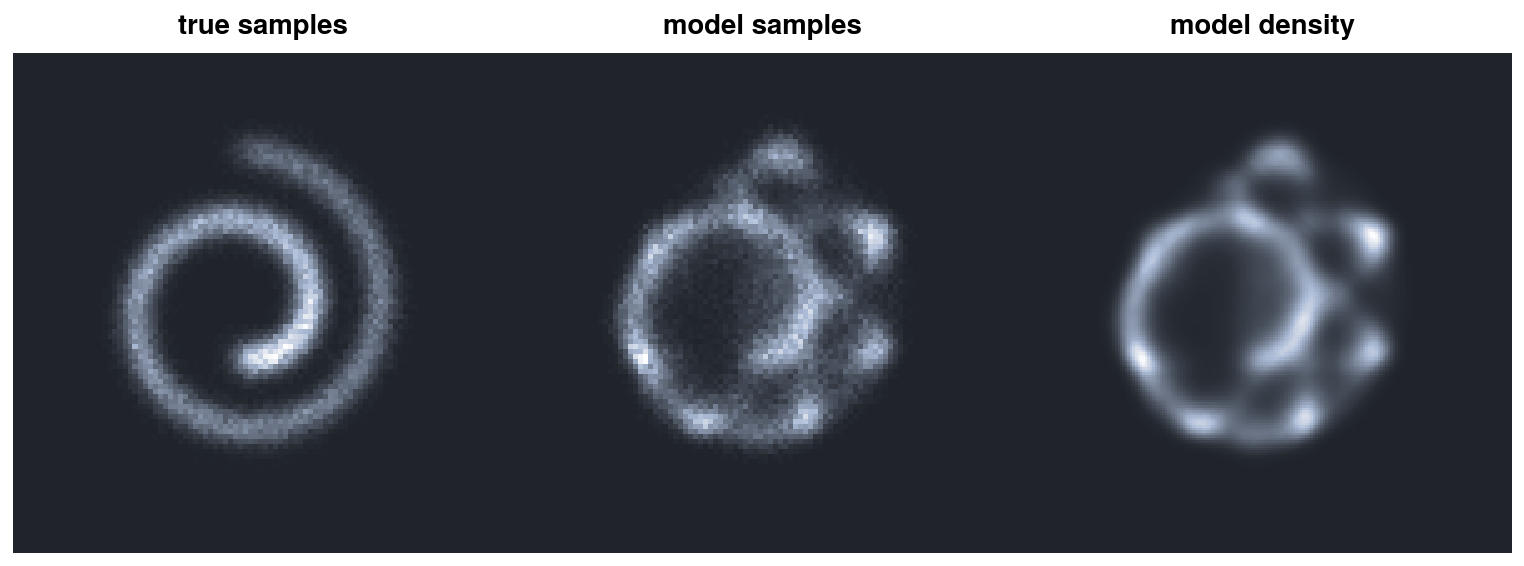

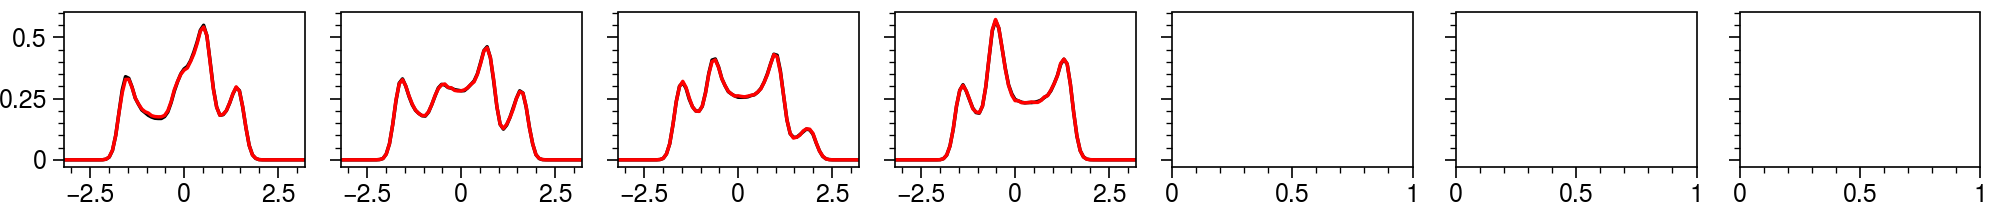

iteration = 4
discrepancy = 0.1070534810423851


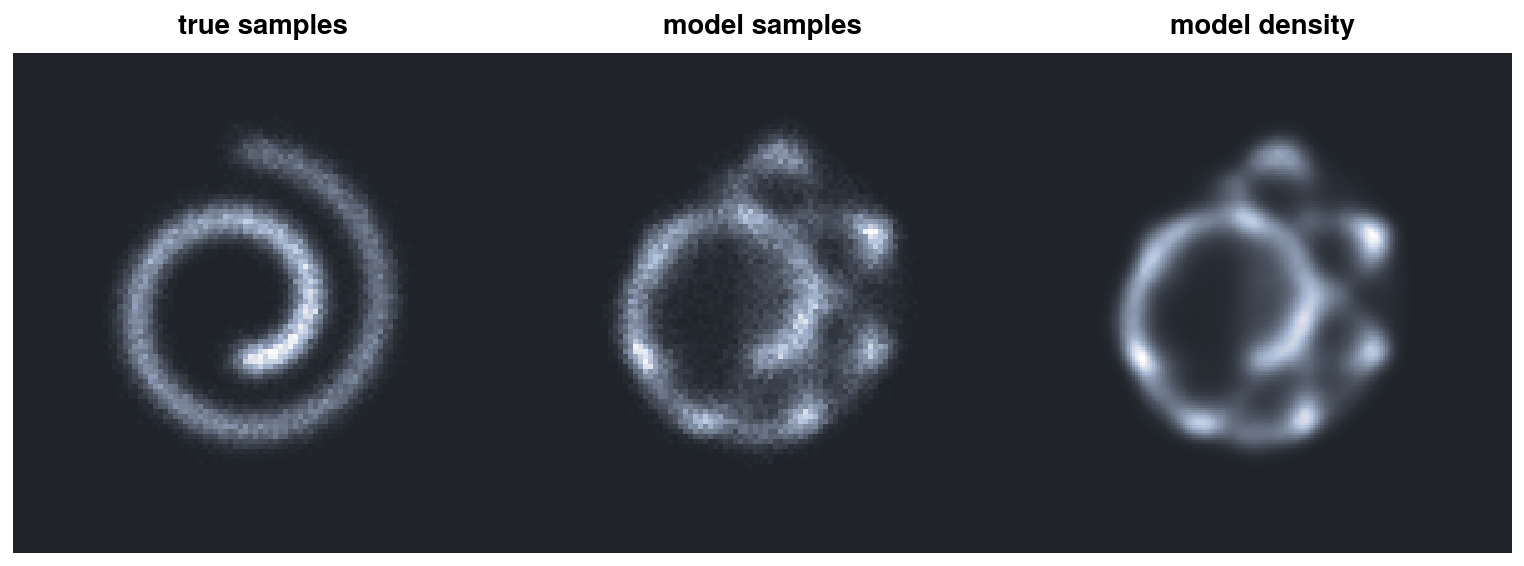

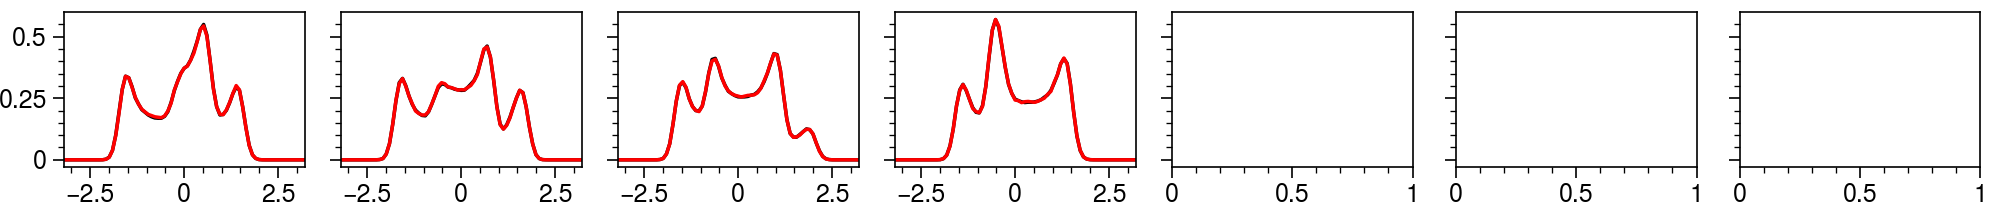

iteration = 5
discrepancy = 0.08420179039239883


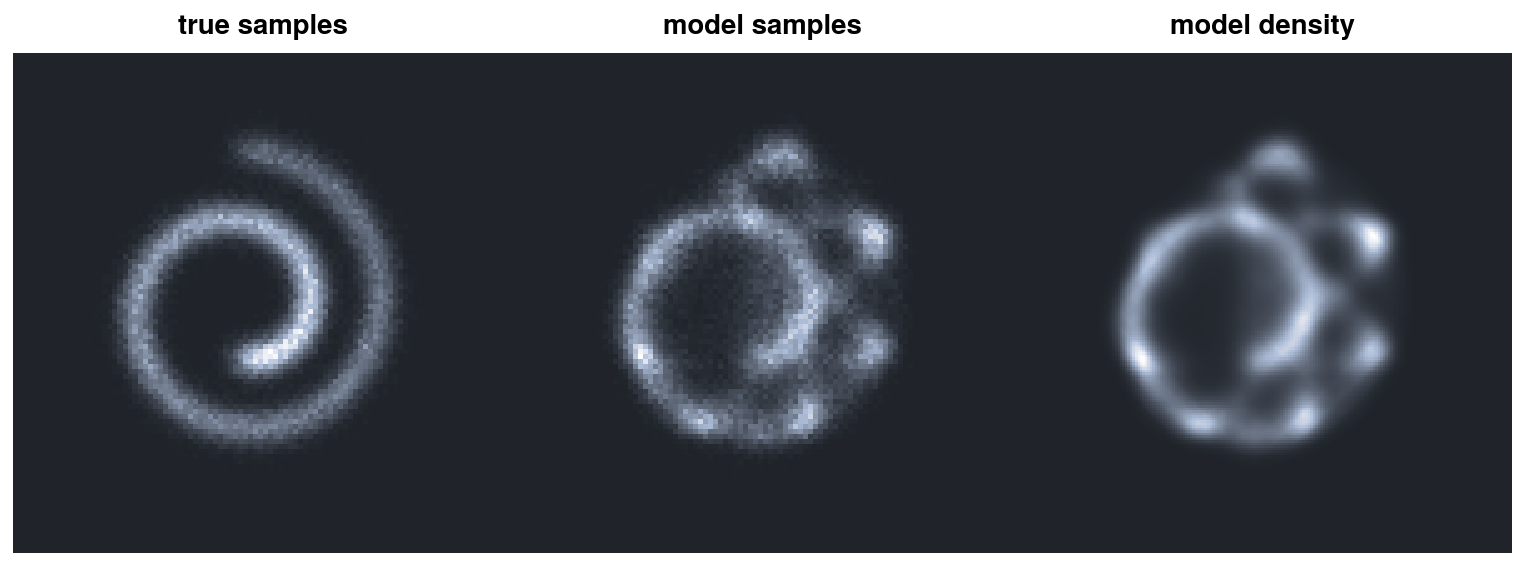

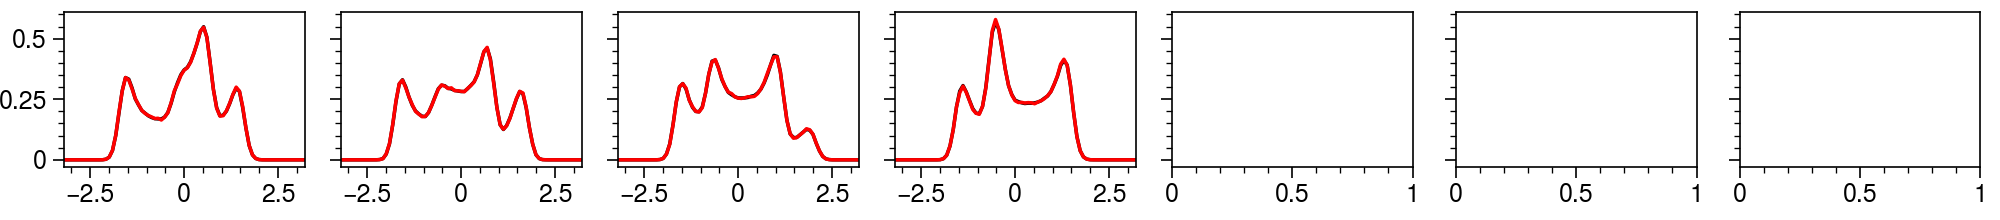

iteration = 6
discrepancy = 0.08649775385856628


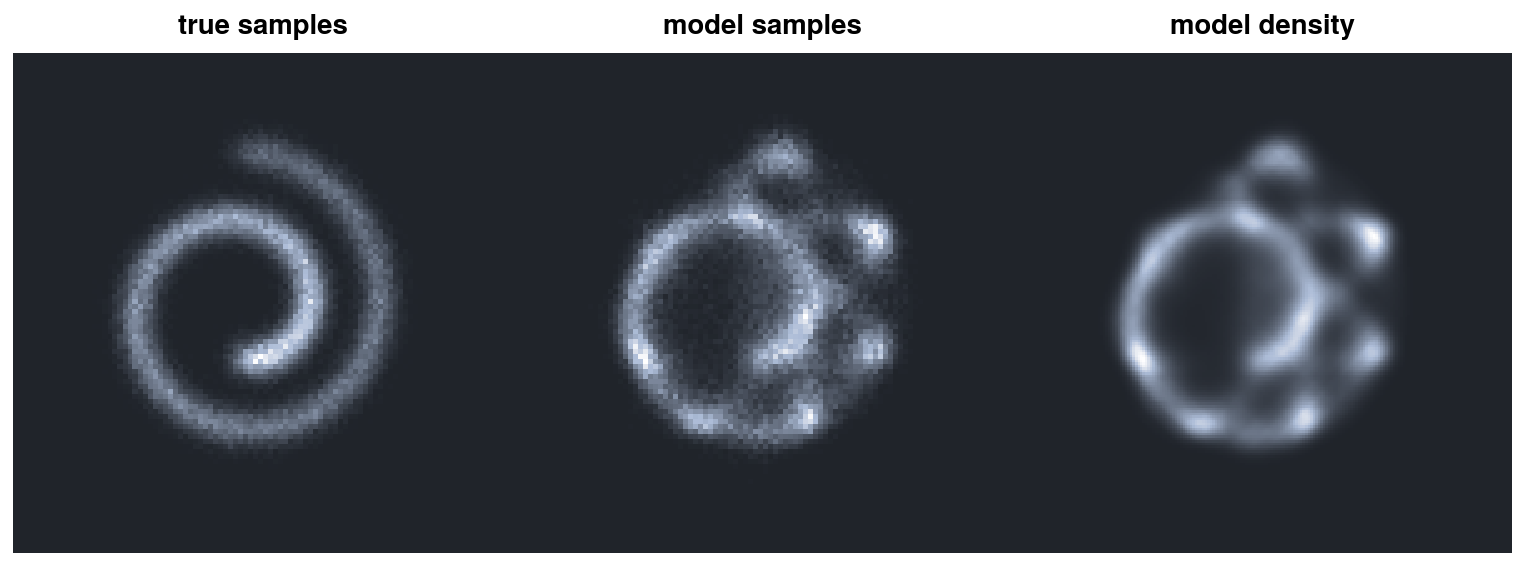

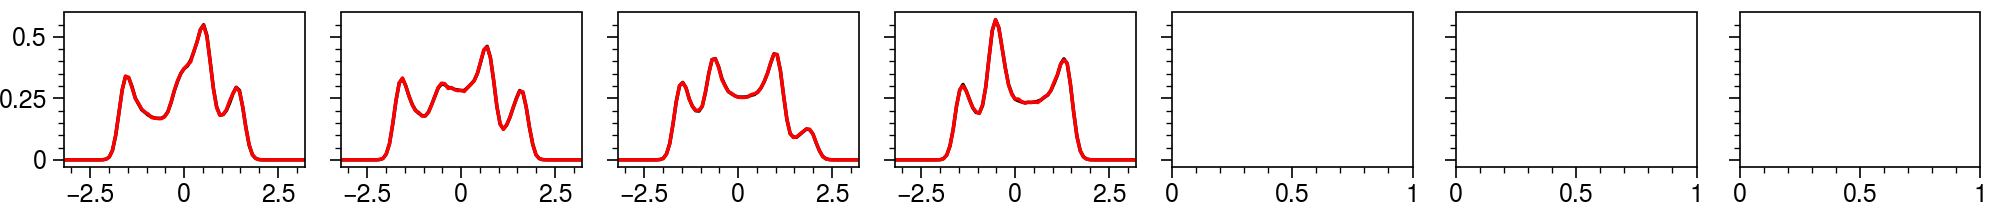

iteration = 7
discrepancy = 0.07884810864925385


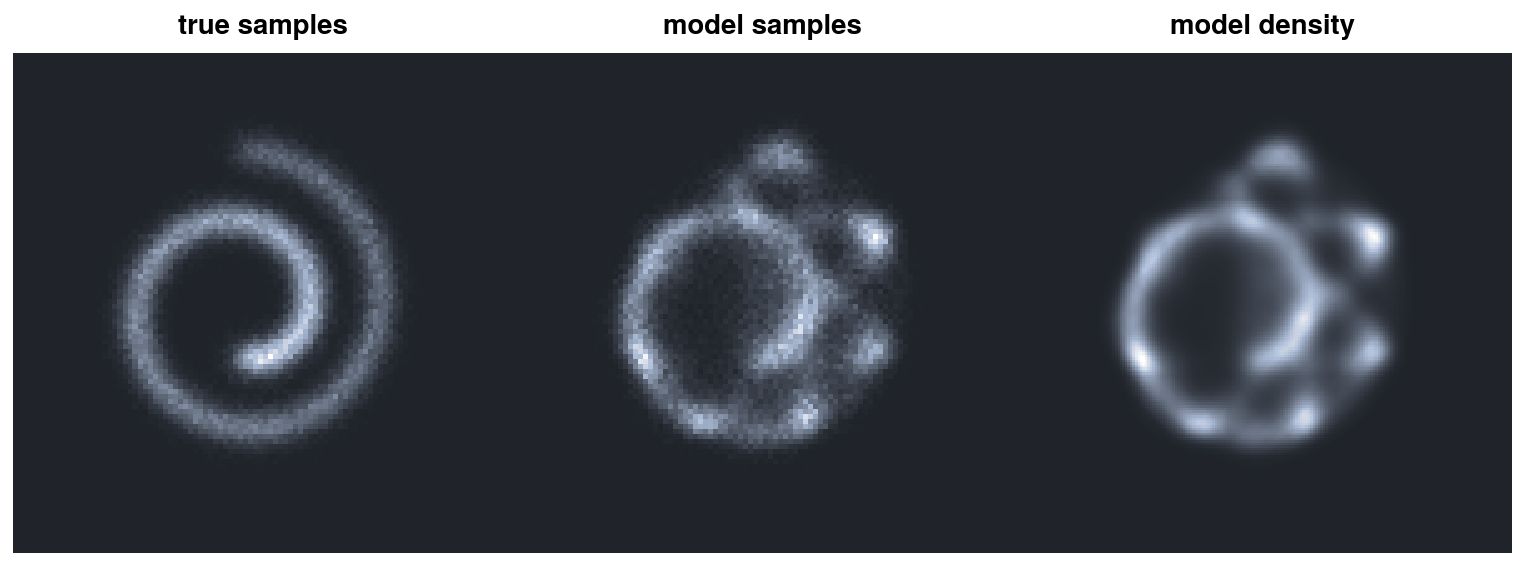

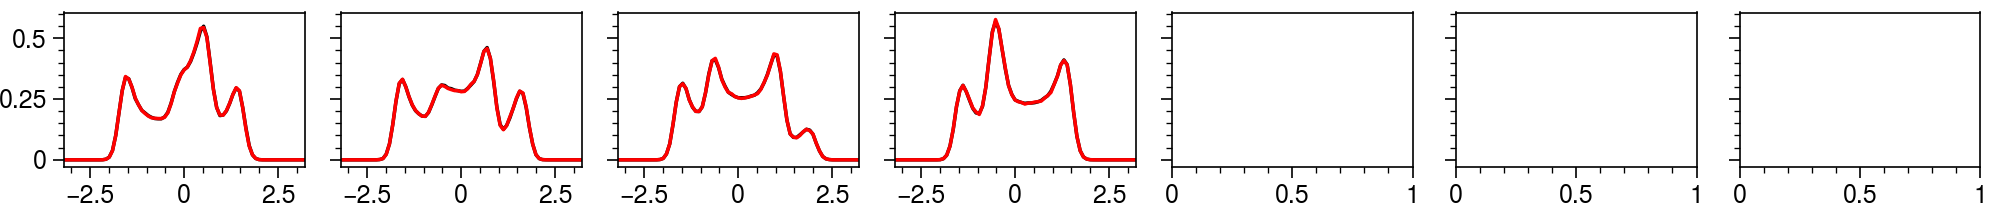

iteration = 8
discrepancy = 0.07853638380765915


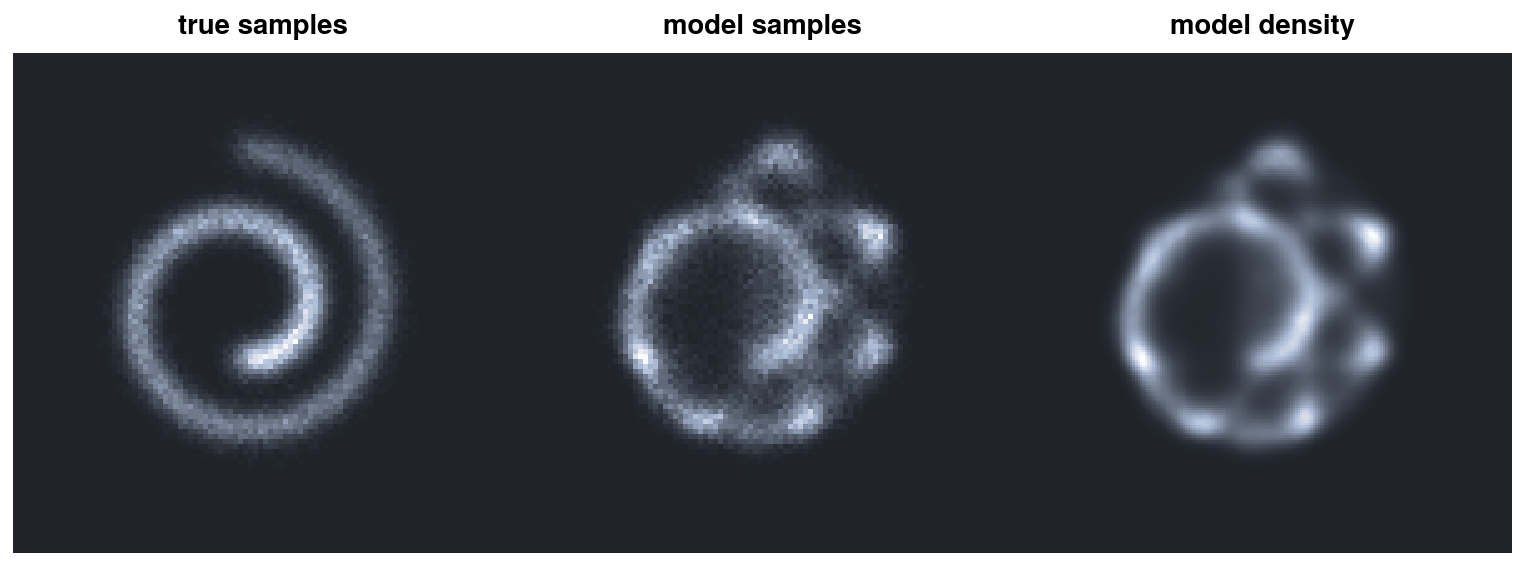

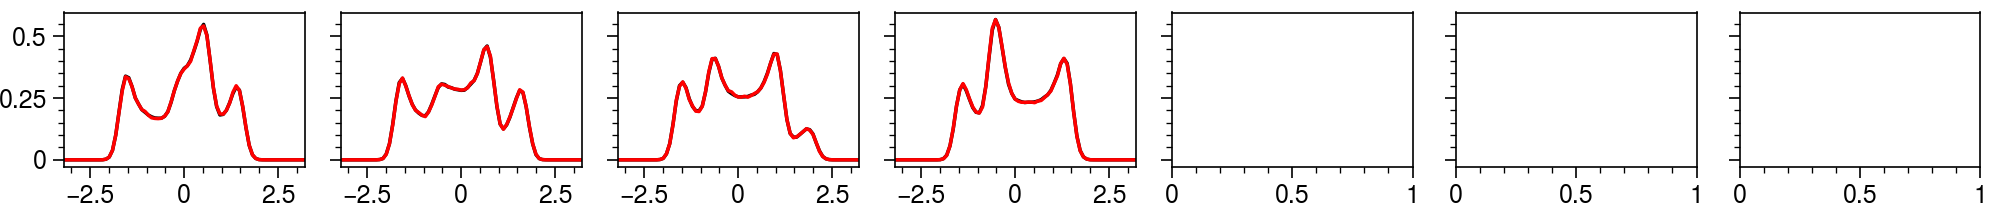

iteration = 9
discrepancy = 0.08725367486476898


In [6]:
# Settings
n_iterations = 10
method = "sample"  # {"integrate", "sample"}
method_kws = dict(
    n=int(1.00e+06)  # number of particles
)  
vis_n_bins = 100
vis_n_samples = int(1.00e+05)
vis_res = 200

for iteration in range(n_iterations):
    # Draw samples from the true distribution.
    x_true = dist.sample(vis_n_samples)
    x_true = grab(x_true)

    # Draw samples from the model distribution.
    x = model.sample(vis_n_samples)
    x = grab(x)
    
    # Evaluate the model distribution on a grid.
    res = vis_res    
    grid_coords = 2 * [torch.linspace(-xmax, xmax, vis_res)]
    grid_points = mf.utils.get_grid_points_torch(grid_coords)
    grid_points = send(grid_points)
    prob = model.prob(grid_points)
    prob = prob.reshape(vis_res, vis_res)
    prob = grab(prob)

    # Simulate the measurements.
    predictions = model.simulate(method=method, **method_kws)

    # Plot density
    fig, axs = pplt.subplots(ncols=3, space=0, xspineloc="neither", yspineloc="neither")
    kws = {
        "cmap": pplt.Colormap("dark_r", space="hpl"),
    }
    for _x, ax in zip([x_true, x], axs):
        ax.hist2d(_x[:, 0], _x[:, 1], bins=vis_n_bins, range=(2 * [(-xmax, xmax)]), **kws)
    axs[2].pcolormesh(grid_coords[0], grid_coords[1], prob.T, **kws)
    axs.format(toplabels=["true samples", "model samples", "model density"])
    pplt.show()
    
    # Plot projections
    ncols = 7
    nrows = 1 + n_meas // ncols
    fig, axs = pplt.subplots(ncols=ncols, nrows=nrows, figheight=(1.1 * nrows), figwidth=10.0)
    for i in range(n_meas):
        kws = dict(lw=1.25)
        bin_coords = mf.utils.centers_from_edges(diagnostic.bin_edges)
        axs[i].plot(grab(bin_coords), grab(measurements[i]), color="black", **kws)
        axs[i].plot(grab(bin_coords), grab(predictions[i]), color="red", **kws)
    pplt.show()

    # Compute the simulation-measurement discrepancy.
    discrepancy = sum(torch.sum(torch.abs(predictions[i] - measurements[i])) for i in range(n_meas)) / n_meas

    # Print a summary.
    print("iteration = {}".format(iteration))
    print("discrepancy = {}".format(discrepancy))

    # Update the lagrange functions.
    model.gauss_seidel_iterate(method=method, **method_kws)